# Demo 3: a demo for comparing classification-based decoding and RSA
Here is a demo based on the data of Bae&Luck's work in 2018. All demo data are based on their Experiment 2's data. You can find more details about the experiment and data information in their paper: Bae, G.Y., Luck, S.J. (2018). Dissociable decoding of spatial attention and working memory from eeg oscillations and sustained potentials. The Journal of Neuroscience, 38(2), 409-422.

In [1]:
! pip install neurora
import os
import sys
import zipfile
import numpy as np
import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from neurora.decoding import tbyt_decoding_kfold
from neurora.rdm_cal import eegRDM
from neurora.rsa_plot import plot_rdm, plot_tbyt_decoding_acc, plot_tbytsim_withstats
from neurora.corr_cal_by_rdm import rdms_corr
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://attachment.zhaokuangshi.cn/BaeLuck_2018jn_data_ERP_5subs.zip'
filename = 'BaeLuck_2018jn_data_ERP_5subs.zip'
data_dir = 'data/'
classification_results_dir = 'classification_results/'
rsa_results_dir = 'rsa_results/'
filepath = data_dir + filename

/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Section 1: Download the data

In [2]:
# Download the data

def schedule(blocknum,blocksize,totalsize):

    if totalsize == 0:
        percent = 0
    else:
        percent = blocknum * blocksize / totalsize
    if percent > 1.0:
        percent = 1.0
    percent = percent * 100
    show_progressbar("Downloading", percent)

exist = os.path.exists(filepath)
if exist == False:
    os.makedirs(data_dir)
    urllib.request.urlretrieve(url, filepath, schedule)
    print('Download completes!')
elif exist == True:
    print('Data already exists!')

# unzip the data

def unzipfile(filepath, data_dir):

    with zipfile.ZipFile(filepath, 'r') as zip:
        zip.extractall(data_dir)
    print("Unzip completes!")

unzipfile(filepath, data_dir)

Data already exists!
Unzip completes!


## Section 2: Classification-based EEG decoding

In [3]:
# data preprocessing for classification-based decoding

# sub_ids
subs = ["201", "202", "203", "204", "205"]
# 被试id
subs = ["201", "202", "203", "204", "205"]

# load data & labels

data = np.zeros([5, 640, 27, 500])
label_ori = np.zeros([5, 640])
label_pos = np.zeros([5, 640])

sub_index = 0
for sub in subs:

    # load certain subject's data
    subdata = sio.loadmat("data/data/ERP" + sub + ".mat")["filtData"]

    # shape of subdata: 640*27*750
    # 640 - number of trials； 27 - number of channels； 750 - number of time-points  
    # sample frequency: 250Hz， time_interval: 0.004s,  from -1.5s to 1.5s

    # from -0.5s to 1.5s
    subdata = subdata[:, :, 250:]

    data[sub_index] = subdata

    sublabel = np.loadtxt("data/labels/ori_" + sub + ".txt")[:, 1]
    label_ori[sub_index] = sublabel
    sublabel = np.loadtxt("data/labels/pos_" + sub + ".txt")[:, 1]
    label_pos[sub_index] = sublabel

    sub_index = sub_index + 1
    
print("Orientation Decoding!\n")

accs = tbyt_decoding_kfold(data, label_ori, n=16, navg=13, time_win=5, time_step=5, nfolds=3, nrepeats=10, smooth=True)

f = h5py.File("classification_results/ori_time-by-time_results.h5", "w")
f.create_dataset("accs", data=accs)
f.close()

print("Position Decoding!\n")

accs = tbyt_decoding_kfold(data, label_pos, n=16, navg=13, time_win=5, time_step=5, nfolds=3, nrepeats=10, smooth=True)

f = h5py.File("classification_results/pos_time-by-time_results.h5", "w")
f.create_dataset("accs", data=accs)
f.close()

Orientation Decoding!

Calculating: [=================================================================================================== ] 99.99%
Decoding finished!

Position Decoding!

Calculating: [=================================================================================================== ] 99.99%
Decoding finished!



## Section 3: Plot the classification-based decoding results

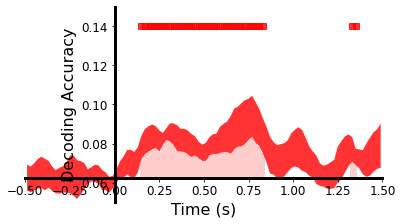

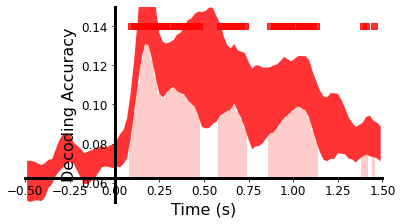

In [4]:
accs_ori = np.array(h5py.File("classification_results/ori_time-by-time_results.h5", "r")["accs"])

plot_tbyt_decoding_acc(accs_ori, start_time=-0.5, end_time=1.5, time_interval=0.02, chance=0.0625, p=0.05, cbpt=False,
                           stats_time=[0, 1.5], color='r', xlim=[-0.5, 1.5], ylim=[0.05, 0.15], figsize=[6.4, 3.6], x0=0,
                           fontsize=16, avgshow=False)

accs_pos = np.array(h5py.File("classification_results/pos_time-by-time_results.h5", "r")["accs"])

plot_tbyt_decoding_acc(accs_pos, start_time=-0.5, end_time=1.5, time_interval=0.02, chance=0.0625, p=0.05, cbpt=False,
                           stats_time=[0, 1.5], color='r', xlim=[-0.5, 1.5], ylim=[0.05, 0.15], figsize=[6.4, 3.6], x0=0,
                           fontsize=16, avgshow=False)

## Section 4: RSA-based Decoding

201
202
203
204
205
Loading data of sub201
Loading data of sub202
Loading data of sub203
Loading data of sub204
Loading data of sub205

Calculate the Orientation RDMs!

Computing RDMs
Calculating: [=====================================================================================               ] 85.20%
RDMs computing finished!

Calculate the Position RDMs!

Computing RDMs
Calculating: [=====================================================================================               ] 85.20%
RDMs computing finished!
Coding RDM!
1


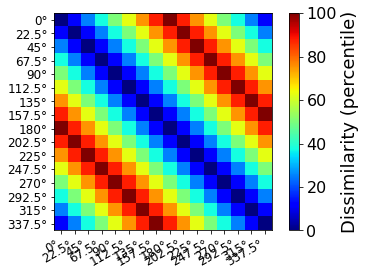


Calculate the Similarities of Orientation!

Computing similarities

Computing finished!

Calculate the Similarities of Position!

Computing similarities

Computing finished!


In [5]:
# data preprocessing for classification-based decoding

if os.path.exists(data_dir + 'data_for_RSA/ERP/') == False:
    os.makedirs(data_dir + 'data_for_RSA/ERP/')

n = len(subs)
subindex = 0
for sub in subs:
    data = sio.loadmat(data_dir + "data/ERP" + sub + ".mat")["filtData"][:, :, 250:]
    # data.shape: n_trials, n_channels, n_times

    ori_label = np.loadtxt(data_dir + "labels/ori_" + sub + ".txt")[:, 1]
    pos_label = np.loadtxt(data_dir + "labels/pos_" + sub + ".txt")[:, 1]

    ori_subdata = np.zeros([16, 40, 27, 500], dtype=np.float)
    pos_subdata = np.zeros([16, 40, 27, 500], dtype=np.float)

    ori_labelindex = np.zeros([16], dtype=np.int)
    pos_labelindex = np.zeros([16], dtype=np.int)

    for i in range(640):
        label = int(ori_label[i])
        ori_subdata[label, ori_labelindex[label]] = data[i]
        ori_labelindex[label] = ori_labelindex[label] + 1
        label = int(pos_label[i])
        pos_subdata[label, pos_labelindex[label]] = data[i]
        pos_labelindex[label] = pos_labelindex[label] + 1

    f = h5py.File(data_dir + "data_for_RSA/ERP/" + sub + ".h5", "w")
    f.create_dataset("ori", data=ori_subdata)
    f.create_dataset("pos", data=pos_subdata)
    f.close()
    print(sub)

nsubs = len(subs)
data_ori_ERP = np.zeros([16, nsubs, 40, 27, 500], dtype=np.float)
data_pos_ERP = np.zeros([16, nsubs, 40, 27, 500], dtype=np.float)
subindex = 0
for sub in subs:
    print('Loading data of sub'+sub)
    f = h5py.File(data_dir+'data_for_RSA/ERP/'+sub+'.h5', 'r')
    ori_subdata = np.array(f['ori'])
    pos_subdata = np.array(f['pos'])
    f.close()
    data_ori_ERP[:, subindex] = ori_subdata
    data_pos_ERP[:, subindex] = pos_subdata
    subindex = subindex + 1

# calculate the RDMs

print("\nCalculate the Orientation RDMs!")
RDM_ori_ERP = eegRDM(data_ori_ERP, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
print("\nCalculate the Position RDMs!")
RDM_pos_ERP = eegRDM(data_pos_ERP, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# shape of RDMs: [5, 100, 16, 16]

# establish a Coding RDM
model_RDM = np.zeros([16, 16], dtype=np.float)
for i in range(16):
    for j in range(16):
        diff = np.abs(i - j)
        if diff <= 8:
            model_RDM[i, j] = diff / 8
        else:
            model_RDM[i, j] = (16 - diff) / 8

conditions = ["0°", "22.5°", "45°", "67.5°", "90°", "112.5°", "135°", "157.5°", "180°",
              "202.5°", "225°", "247.5°", "270°", "292.5°", "315°", "337.5°"]

# plot the Coding RDM
print("Coding RDM!")
plot_rdm(model_RDM, percentile=True, conditions=conditions)

# calculate the CTSimilarities between CTRDMs and Coding RDM
print("\nCalculate the Similarities of Orientation!")
Sim_ori_ERP = rdms_corr(model_RDM, RDM_ori_ERP)
print("\nCalculate the Similarities of Position!")
Sim_pos_ERP = rdms_corr(model_RDM, RDM_pos_ERP)

## Section 5: Plot the RSA-based decoding results

Orientation RSA-based Decoding Results!


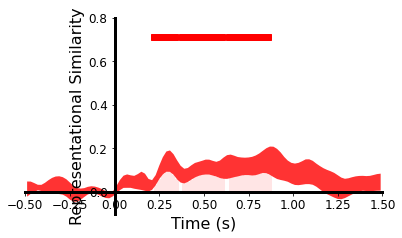

Position RSA-based Decoding Results!


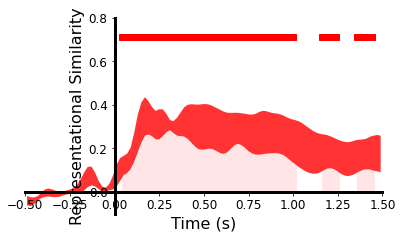

0

In [6]:
# plot orientation decoding results
print("Orientation RSA-based Decoding Results!")
plot_tbytsim_withstats(Sim_ori_ERP, start_time=-0.5, end_time=1.5, time_interval=0.02, smooth=True, p=0.05, cbpt=False,
                           stats_time=[0, 1.5], color='r', xlim=[-0.5, 1.5], ylim=[-0.1, 0.8], figsize=[6.4, 3.6], x0=0,
                           fontsize=16, avgshow=False)

# plot position decoding results
print("Position RSA-based Decoding Results!")
plot_tbytsim_withstats(Sim_pos_ERP, start_time=-0.5, end_time=1.5, time_interval=0.02, smooth=True, p=0.05, cbpt=False,
                           stats_time=[0, 1.5], color='r', xlim=[-0.5, 1.5], ylim=[-0.1, 0.8], figsize=[6.4, 3.6], x0=0,
                           fontsize=16, avgshow=False)